<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/focus/fb_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1787, done.
remote: Counting objects: 100% (514/514), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 1787 (delta 314), reused 474 (delta 293), pack-reused 1273
Receiving objects: 100% (1787/1787), 79.65 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (1135/1135), done.
Updating files: 100% (57/57), done.
Mounted at /content/drive


# Set up

In [ ]:
# Choose settings for the parameters part
estimate_parameters=True # to estimate parameters
name_parameters='params_dict_trial_fb_1015' # good for ZIE separated

n=500 # number of threads
h=100 # number of hours considered

## Prepare Data

In [3]:
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
fb=filter_first_h(fb,h)

fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
fb['year'].unique()

fb15 = fb[fb['year'] == 2015]
fb14 = fb[fb['year'] == 2014]
fb13 = fb[fb['year'] == 2013]
fb12 = fb[fb['year'] == 2012]
fb11 = fb[fb['year'] == 2011]
fb10 = fb[fb['year'] == 2010]

years = [2010, 2011, 2012, 2013, 2014, 2015]
names = [f'fb{year}' for year in years]
datas = [fb[fb['year'] == year] for year in years]

In [4]:
# Group by user_id, post_id, and year, and count comments
grouped = fb.groupby(['user_id', 'post_id', 'year'])['comment_id'].count().reset_index()
mean_comments_per_year = grouped.groupby('year')['comment_id'].mean().reset_index()

## Search parameters

In [5]:
if estimate_parameters:
  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)
else:
  with open('/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json', 'r') as file:
    params_dict = json.load(file)
print(params_dict)

  0%|          | 0/6 [00:00<?, ?it/s]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
 17%|█▋        | 1/6 [00:04<00:22,  4.43s/it]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_co

{'fb2010': {'gamma': 2.34779898274137, 'a': 0.789611056770582, 'b': 3751.772001507581, 'loc': 0.0009999999999999998, 'scale': 55.4512165303656, 'alpha': 0.9005015286317887, 'lambda': 0.9813634300173972, 'a_IAT': 0.06207340578430249, 'b_IAT': 5.274369310816735, 'af_IAT': 0.08257603929286418, 'bf_IAT': 2.990117799508881}, 'fb2011': {'gamma': 2.1949997675752484, 'a': 0.29049239606870936, 'b': 21.21460596513986, 'loc': 0.0009999999999999998, 'scale': 2.7382620353682383, 'alpha': 0.8970483369836499, 'lambda': 0.9831237253532501, 'a_IAT': 0.03763346800768959, 'b_IAT': 5.2101491389171315, 'af_IAT': 0.06055781055932674, 'bf_IAT': 3.05530440064521}, 'fb2012': {'gamma': 2.0664242009936755, 'a': 0.580282810342951, 'b': 338.9440914608882, 'loc': 0.0009999999999999998, 'scale': 7.882825176114929, 'alpha': 0.908766354643123, 'lambda': 0.9834628415951596, 'a_IAT': 0.020711134520078188, 'b_IAT': 2.8880356120508335, 'af_IAT': 0.03070544290787656, 'bf_IAT': 1.9210538839732576}, 'fb2013': {'gamma': 1.967

In [6]:
df = pd.DataFrame.from_dict(params_dict, orient='index')[['alpha','lambda']].to_csv()

## Simulate synthetic data

In [7]:

time_intervals = np.arange(0, 1, 0.05)

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]
    datas_processed_s=[]
    datas_processed_o=[]
    names_processed=[]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)# peensaree a come limitar i valori dell funzionee IAT senza crear break infiniti
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t
    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)



Processing DataFrame: 100%|██████████| 1000/1000 [00:23<00:00, 41.81it/s]


### Dynamic

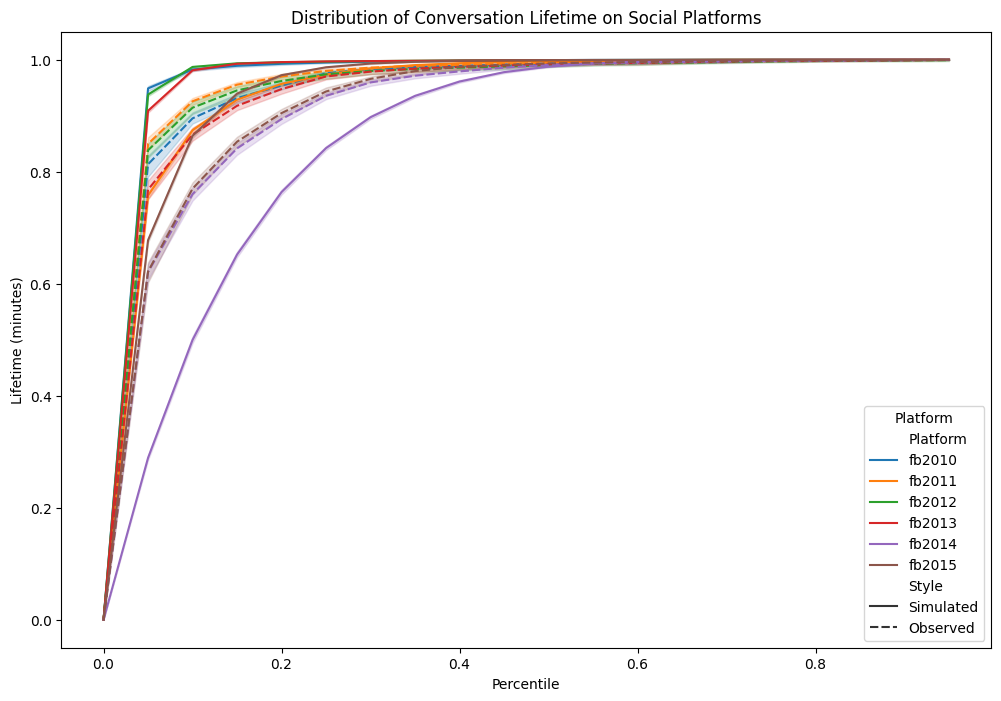

In [8]:
# Prepare data
df_all = df_all_M1.sort_values(by='Style')

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100))
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

## Participation

100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


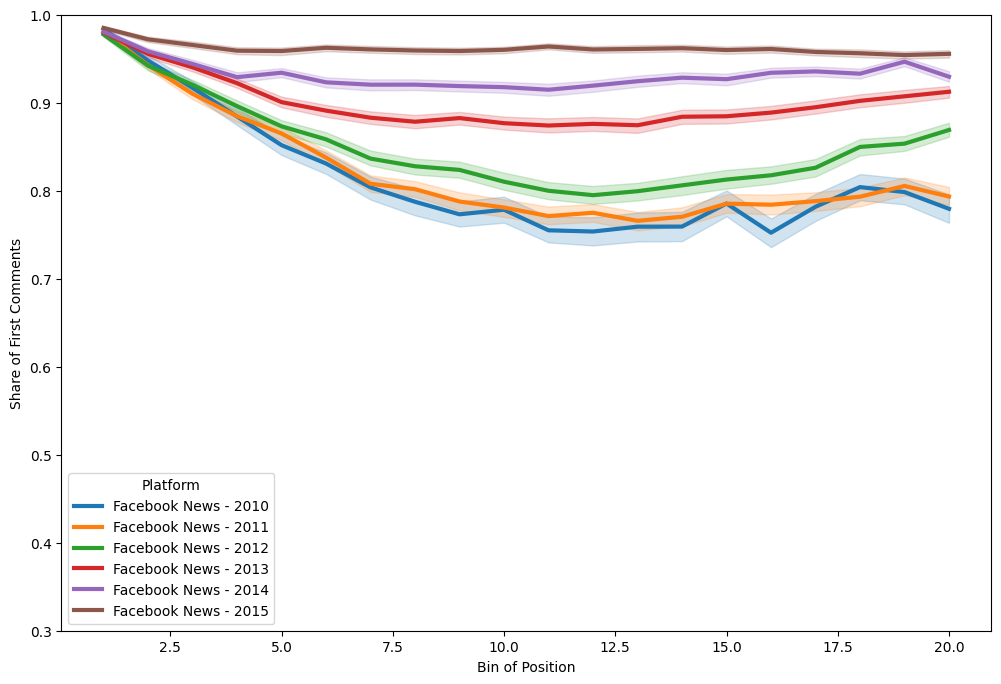

100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


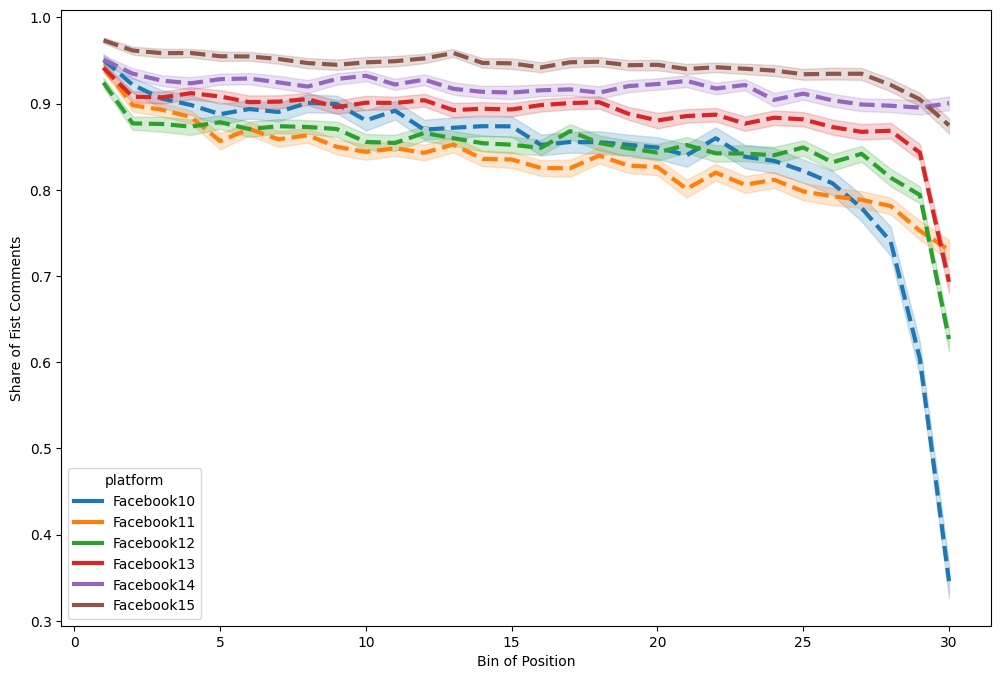

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames
fb2010o_M1['platform'] = 'Facebook News - 2010'
fb2011o_M1['platform'] = 'Facebook News - 2011'
fb2012o_M1['platform'] = 'Facebook News - 2012'
fb2013o_M1['platform'] = 'Facebook News - 2013'
fb2014o_M1['platform'] = 'Facebook News - 2014'
fb2015o_M1['platform'] = 'Facebook News - 2015'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([fb2010o_M1,fb2011o_M1,fb2012o_M1,fb2013o_M1,fb2014o_M1,fb2015o_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')
    # Determine the number of bins
    num_bins = 20

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

plt.figure(figsize=(12, 8))
agg_activity_obs['Platform']=agg_activity_obs['platform']
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='Platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3
)
plt.ylabel('Share of First Comments')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.ylim(0.3,1)
plt.show()


fb2010s_M1['platform'] = 'Facebook10'
fb2011s_M1['platform'] = 'Facebook11'
fb2012s_M1['platform'] = 'Facebook12'
fb2013s_M1['platform'] = 'Facebook13'
fb2014s_M1['platform'] = 'Facebook14'
fb2015s_M1['platform'] = 'Facebook15'

# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([fb2010s_M1,fb2011s_M1,fb2012s_M1,fb2013s_M1,fb2014s_M1,fb2015s_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()



plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('')
plt.ylabel('Share of Fist Comments')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()



5


In [10]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')
rd=filter_first_h(rd,h)
rd['year'] = pd.to_datetime(rd['thread_birth']).dt.year

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')
vo=filter_first_h(vo,h)
vo['year'] = pd.to_datetime(vo['thread_birth']).dt.year

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')
gb=filter_first_h(gb,h)
gb['year'] = pd.to_datetime(gb['thread_birth']).dt.year
gb['social']='Gab'

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
fb=filter_first_h(fb,h)
fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year



df=pd.concat([rd,vo,gb,fb])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:

df=pd.concat([rd,vo,gb,fb])

# Definire la palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

sottodataset = {}

# Iteriamo attraverso i gruppi unici di 'social' e 'year'
for (social, year), group in df.groupby(['social', 'year']):
    # Creiamo il nome del dataset
    nome_dataset = f"{social}_{year}"
    # Aggiungiamo il gruppo al dizionario
    sottodataset[nome_dataset] = group

names=list(sottodataset.keys())
datas=list(sottodataset.values())
params_dict = process_social_platform(names, datas)
file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'w') as file:
    json.dump(params_dict, file)

# Dizionario con i valori da annotare
values = {
    'Facebook_2010': 0.900502,
    'Facebook_2011': 0.897048,
    'Facebook_2012': 0.908766,
    'Facebook_2013': 0.934801,
    'Facebook_2014': 0.954594,
    'Facebook_2015': 0.969746,
    'Gab_2016': 0.849926,
    'Gab_2017': 0.703350,
    'Gab_2018': 0.748802,
    'Reddit_2018': 0.745840,
    'Reddit_2019': 0.806349,
    'Reddit_2020': 0.784444,
    'Reddit_2021': 0.759946,
    'Reddit_2022': 0.754343,
    'Voat_2015': 0.677147,
    'Voat_2016': 0.701203,
    'Voat_2017': 0.740417,
    'Voat_2018': 0.728018,
    'Voat_2019': 0.751098,
    'Voat_2020': 0.737628
}

# Raggruppare i dati
grouped = df.groupby(['post_id', 'year', 'social'])['user_id'].nunique().reset_index()
social_order = ['Reddit', 'Voat', 'Gab', 'Facebook']

# Sort 'grouped' DataFrame by 'social' column based on 'social_order'
grouped['social'] = pd.Categorical(grouped['social'], categories=social_order, ordered=True)
grouped_sorted = grouped.sort_values(by='social')

# Creare il grafico
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='year', y='user_id', hue='social', palette=palette, marker='o')
grouped = grouped.groupby([ 'year', 'social'])['user_id'].mean().reset_index()
for index, row in grouped.iterrows():
    social_year = f"{row['social']}_{row['year']}"
    if social_year in values:
        value = round(values[social_year], 2)
        plt.text(row['year'], row['user_id'], str(value), color='#013220', ha='right')

# Adding a dummy scatter plot with a label for legend
plt.scatter([], [], label=r'$\alpha$ values', color='#013220')

plt.title('Trend of Number of users over the Years for Platform')
plt.xlabel('Year')
plt.ylabel('Number of users in a thread')  # Corrected typo in ylabel
plt.legend(title='Platform')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import Polynomial

# Supponiamo che i DataFrame 'rd', 'vo', 'gb', 'fb' siano già stati definiti

# Concatenare i DataFrame
datas = pd.concat([rd, vo, gb, fb])

# Calcolo dei gruppi e delle medie
gr_a = datas.groupby(['post_id', 'user_id', 'social'])['comment_id'].count().reset_index(name='comment_count')
gr_a['single']=gr_a['comment_count']==1
mean_comments = gr_a.groupby(['post_id', 'social'])['single'].mean().reset_index(name='mean_comment_count')

gr_b = datas.groupby(['post_id', 'social'])['user_id'].nunique().reset_index(name='unique_user_count')
gr_b = gr_b[gr_b['unique_user_count'] > 50]

# Merge dei DataFrame
merged_df = pd.merge(mean_comments, gr_b, on=['post_id', 'social'])

# Definire la palette di colori
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}



In [ ]:
# Creazione degli scatterplot
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()


for i, social in enumerate(merged_df['social'].unique()):
    subset = merged_df[merged_df['social'] == social]
    x = np.log(subset['unique_user_count'])
    y =(subset['mean_comment_count'])

    # Scatter plot
    axes[i].scatter(x, y, color=palette[social], alpha=0.2, edgecolors='w', linewidth=0.8, label=social)

    # Fit polinomiale (grado 2)
    p = Polynomial.fit(x, y,3)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = p(x_fit)

    # Plot della funzione di fitting
    axes[i].plot(x_fit, y_fit, color='gray', linestyle='--', linewidth=2)

    # Titoli e etichette
    axes[i].set_title(f'{social} ')
    axes[i].set_xlabel('Log Number of users')
    axes[i].set_ylabel('Share of interactions of size 1')
    axes[i].set_xlim(4,10)

plt.tight_layout()
plt.show()
